# 1D MT forward modelling

## Learning goals

- Understand the sensitivity of apparent resistivity and phase with regard to layered structure
- Understand the concept of an equivalent conductance
- Conduct manual fitting of the field data

In [1]:
import numpy as np
from simpeg.electromagnetics import natural_source as nsem
from simpeg import maps
import matplotlib.pyplot as plt
import matplotlib
from simpeg.utils import plot_1d_layer_model
from discretize import TensorMesh
import warnings
warnings.filterwarnings("ignore")

## Setup 1D MT simulation 

In [2]:
frequencies = np.logspace(-5, 5, 101)
layer_thicknesses = np.array([1000, 1000])
rho = np.array([1000., 10, 1000.])
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


model_mapping = maps.IdentityMap(nP=len(rho))

receivers_list = [
    nsem.receivers.PointNaturalSource(component="app_res"),
    nsem.receivers.PointNaturalSource(component="phase"),
]

source_list = []
for freq in frequencies:
    source_list.append(nsem.sources.Planewave(receivers_list, freq))

survey = nsem.survey.Survey(source_list)

simulation = nsem.simulation_1d.Simulation1DRecursive(
    survey=survey, 
    sigmaMap=sigma_map,
    thicknessesMap=layer_map,
)

true_model = np.r_[np.log(1./rho), np.log(layer_thicknesses)]

dpred = simulation.dpred(true_model)

In [3]:
import matplotlib.gridspec as gridspec
def calculate_response(rho1, rho2, rho3, z, t):
    model = np.log(np.r_[1./rho3, 1./rho2, 1./rho1, t, z])
    pred = simulation.dpred(model)
#     print (simulation.rho, simulation.thicknesses)
    return pred

def plot_results(rho1, rho2, rho3, z, t, add_noise, rerr_amp, floor_phase, plot_option):        
    pred = calculate_response(rho1, rho2, rho3, z, t)
    amp = pred.reshape((len(frequencies), 2))[:,0]
    phase = pred.reshape((len(frequencies), 2))[:,1]    
    if add_noise:
        noise = np.c_[np.random.randn(amp.size)*rerr_amp*abs(amp), np.random.randn(amp.size)*floor_phase].flatten()
        pred += noise
    fig = plt.figure(figsize=(16, 5))
    gs = gridspec.GridSpec(1, 5, figure=fig)

    ax0 = fig.add_subplot(gs[0, 0])
    layer_thicknesses = np.array([z, t])
    rho = np.r_[rho1, rho2, rho3]
    plot_1d_layer_model(layer_thicknesses, rho, ax=ax0, color="k", **{'label':'True'})
    ax0.set_xlabel("Resistivity ($\Omega$m)")
    ax0.set_xlim(1, 10000)
    
    ax = fig.add_subplot(gs[0, 2:])
    if (plot_option == 'app_res') or (plot_option == 'both'):
        ax.loglog(frequencies, pred.reshape((len(frequencies), 2))[:,0], color='C0', label='AppRes.', lw=3)
    if (plot_option == 'phase') or (plot_option == 'both'):
        ax.loglog(frequencies[0], pred.reshape((len(frequencies), 2))[0,0], color='C1', label='Phase')
        ax_1 = ax.twinx()
        ax_1.plot(frequencies, pred.reshape((len(frequencies), 2))[:,1], color='C1', lw=3)
        ax_1.set_ylim(0, 90)    
        ax_1.set_ylabel("Phase ($\degree$)")        
    ax.set_xlabel("Frequency (Hz)")    
    ax.set_ylim(1, 10000)
    ax.grid(True, which='both', alpha=0.5)
    ax.set_ylabel("Apparent resistivity ($\Omega$m)")
    ax.legend(bbox_to_anchor=(-0.1, 1))
    ax.set_xlim(1e5, 1e-5)
    plt.show()
#     plt.tight_layout()

## Explore MT responses with variable 1D structure

In [4]:
from ipywidgets import widgets, interact

In [5]:
Q = interact(
    plot_results, 
    rho1=widgets.FloatLogSlider(base=10, value=100, min=0, max=4, continuous_update=True, description="$\\rho_1$"),
    rho2=widgets.FloatLogSlider(base=10, value=5, min=0, max=4, continuous_update=True, description="$\\rho_2$"),
    rho3=widgets.FloatLogSlider(base=10, value=100, min=0, max=4, continuous_update=True, description="$\\rho_3$"),
    z=widgets.FloatLogSlider(base=10, value=3000, min=0, max=5, continuous_update=True, description="$z$"),
    t=widgets.FloatLogSlider(base=10, value=1000, min=0, max=5, continuous_update=True, description="$thk$"),
    add_noise=widgets.Checkbox(),
    rerr_amp=widgets.FloatText(value=0.1),
    floor_phase=widgets.FloatText(value=2), 
    plot_option=widgets.RadioButtons(options=['app_res', 'phase', 'both'])
)
Q

interactive(children=(FloatLogSlider(value=100.0, description='$\\rho_1$'), FloatLogSlider(value=5.0, descript…

<function __main__.plot_results(rho1, rho2, rho3, z, t, add_noise, rerr_amp, floor_phase, plot_option)>

## Equivalent conductance

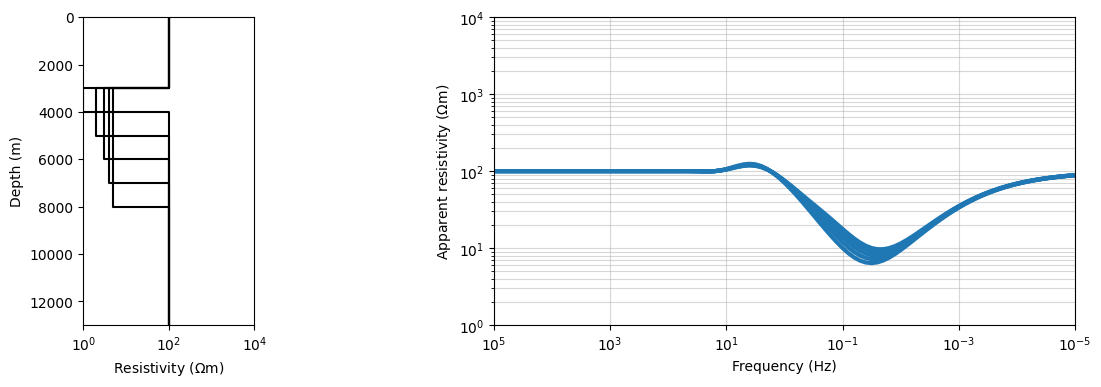

In [6]:
rho1 = 100.
rho3 = 100.
rho2 = 1.
z = 3000
t = 1000
# conductance
S = 1./rho2 * t
t_iter = np.arange(5) * 1000 + 1000

fig = plt.figure(figsize=(16*0.8, 5*0.8))
gs = gridspec.GridSpec(1, 5, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax = fig.add_subplot(gs[0, 2:])

for ii in range(len(t_iter)):
    rho2_iter = 1./(S/t_iter[ii])
    pred = calculate_response(rho1, rho2_iter, rho3, z, t_iter[ii])
    amp = pred.reshape((len(frequencies), 2))[:,0]
    phase = pred.reshape((len(frequencies), 2))[:,1]    
    layer_thicknesses = np.array([z, t_iter[ii]])
    rho = np.r_[rho1, rho2_iter, rho3]
    plot_1d_layer_model(layer_thicknesses, rho, ax=ax0, color="k", **{'label':'True'})
    ax0.set_xlabel("Resistivity ($\Omega$m)")
    ax0.set_xlim(1, 10000)

    
    ax.loglog(frequencies, pred.reshape((len(frequencies), 2))[:,0], color='C0', lw=3)
    ax.set_xlabel("Frequency (Hz)")    
    ax.set_ylim(1, 10000)
    ax.grid(True, which='both', alpha=0.5)
    ax.set_ylabel("Apparent resistivity ($\Omega$m)")
#     ax.legend(bbox_to_anchor=(-0.1, 1))
    ax.set_xlim(1e5, 1e-5)

## Manual fitting of the data

In [7]:
from mtpy import MTCollection

In [8]:
mc = MTCollection()
mc.open_collection("../../data/transfer_functions/yellowstone_mt_collection.h5")

In [9]:
from ipywidgets import widgets, interact
station_names = mc.dataframe.station.values
def foo(name):
    tf = mc.get_tf(name)
    tf.plot_mt_response()

['SR209', 'YNP05S']

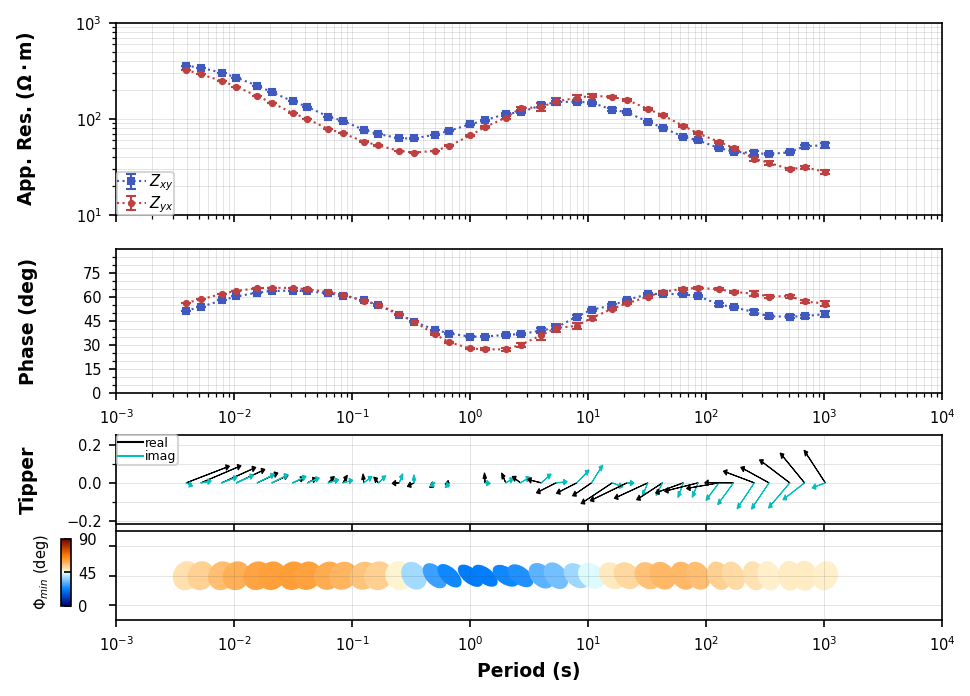

interactive(children=(Select(description='name', index=144, options=('IDD11', 'IDD12', 'IDE11', 'IDE12', 'IDF1…

In [10]:
Q = interact(foo, name=widgets.Select(options=station_names, value='YNP05S'))

In [11]:
matplotlib.rcParams['font.size'] = 12

24:10:14T16:26:29 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID YNP05S. Suggest setting survey, otherwise returning the TF from survey YSBB.


Text(0.5, 1.0, 'YNP05S')

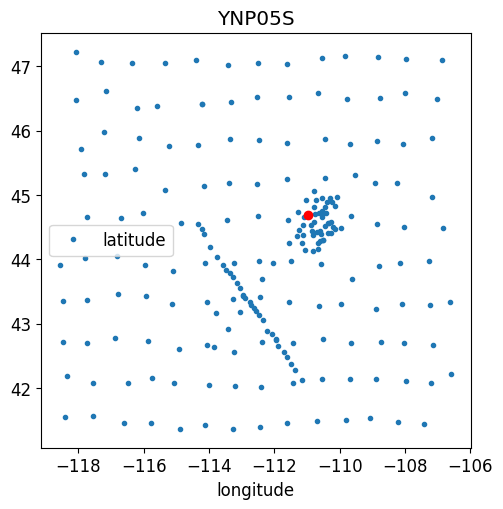

In [12]:
name = Q.widget.kwargs['name']
tf = mc.get_tf(name)
fig, ax = plt.subplots(1,1, figsize=(5,5))
mc.dataframe.plot(x='longitude', y='latitude', marker='.', linestyle='None', ax=ax)
ax.plot(tf.longitude, tf.latitude, 'ro')
ax.set_title(name)

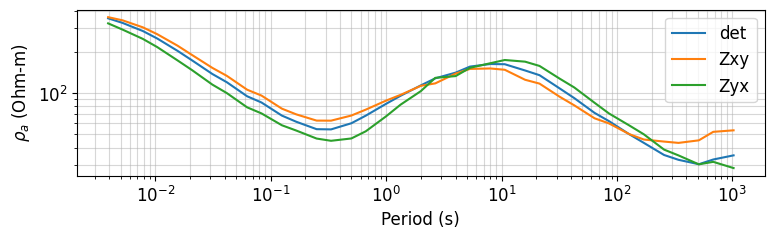

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8, 2))
ax.loglog(tf.Z.period, tf.Z.res_det, label='det')
ax.loglog(tf.Z.period, tf.Z.res_xy, label='Zxy')
ax.loglog(tf.Z.period, tf.Z.res_yx, label='Zyx')
ax.set_xlabel("Period (s)")
ax.set_ylabel("$\\rho_a$ (Ohm-m)")
ax.legend()
ax.grid(which='both', alpha=0.5)

In [14]:
frequencies_fit = 1./tf.period
source_list_fit = []
for freq in frequencies_fit:
    source_list_fit.append(nsem.sources.Planewave(receivers_list, freq))

survey_fit = nsem.survey.Survey(source_list_fit)

simulation_fit = nsem.simulation_1d.Simulation1DRecursive(
    survey=survey_fit, 
    sigmaMap=sigma_map,
    thicknessesMap=layer_map,
)

In [15]:
import matplotlib.gridspec as gridspec
def predict_mt_response(rho1, rho2, rho3, z, t):
    model = np.log(np.r_[1./rho3, 1./rho2, 1./rho1, t, z])
    pred = simulation_fit.dpred(model)
    return pred

In [16]:
def fit_mt_response(rho1, rho2, rho3, z, t):        
    pred = predict_mt_response(rho1, rho2, rho3, z, t)
    app_res = pred.reshape((len(frequencies_fit), 2))[:,0]
    fig = plt.figure(figsize=(16*0.7, 5*0.7))
    gs = gridspec.GridSpec(1, 5, figure=fig)

    ax0 = fig.add_subplot(gs[0, 0])
    layer_thicknesses = np.array([z, t])
    rho = np.r_[rho1, rho2, rho3]
    plot_1d_layer_model(layer_thicknesses, rho, ax=ax0, color="k", **{'label':'True'})
    ax0.set_xlabel("Resistivity ($\Omega$m)")
    ax0.set_xlim(0.1, 10000)
    
    ax = fig.add_subplot(gs[0, 2:])
    ax.loglog(tf.period, tf.Z.res_det, color='C0', label='Obs.', lw=3, marker='o', linestyle='None')
    ax.loglog(tf.period, app_res, color='C1', label='Pred.', lw=3)
    ax.set_xlabel("Periods (s)")    
    ax.set_ylim(tf.Z.res_det.min()/2, tf.Z.res_det.max()*2)
    ax.grid(True, which='both', alpha=0.5)
    ax.set_ylabel("Apparent resistivity ($\Omega$m)")
    ax.legend(bbox_to_anchor=(-0.1, 1))
    ax.set_title(name)
    plt.show()
#     plt.tight_layout()

In [17]:
Q_fit = interact(
    fit_mt_response, 
    rho1=widgets.FloatLogSlider(base=10, value=np.median(tf.Z.res_det), min=-1, max=4, continuous_update=True, description="$\\rho_1$"),
    rho2=widgets.FloatLogSlider(base=10, value=np.median(tf.Z.res_det), min=-1, max=4, continuous_update=True, description="$\\rho_2$"),
    rho3=widgets.FloatLogSlider(base=10, value=np.median(tf.Z.res_det), min=-1, max=4, continuous_update=True, description="$\\rho_3$"),
    z=widgets.FloatLogSlider(base=10, value=3000, min=0, max=5, continuous_update=True, description="$z$"),
    t=widgets.FloatLogSlider(base=10, value=1000, min=0, max=5, continuous_update=True, description="$thk$"),
)

interactive(children=(FloatLogSlider(value=94.8554279515094, description='$\\rho_1$', min=-1.0), FloatLogSlide…

{'rho1': 316.2277660168379,
 'rho2': 12.589254117941675,
 'rho3': 316.2277660168379,
 'z': 630.957344480193,
 't': 316.2277660168379}

In [18]:
Q_fit.widget.kwargs

{'rho1': 94.8554279515094,
 'rho2': 94.8554279515094,
 'rho3': 94.8554279515094,
 'z': 3000.0,
 't': 1000.0}